In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [ ]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#### Implement a model with convolution encoder, recurrent module and a classifier:

In [24]:
class ConvBlock(nn.Module):
    """
    Encapuslation of a convolutional block (conv + normalization + activation + pooling)
    """
    def __init__(self, in_ch, out_ch, k_size, pool=False, norm=True):
        super().__init__()
        self.module = nn.Sequential()
        self.module.add_module("Conv", nn.Conv2d(in_ch, out_ch, k_size))
        if norm:
            self.module.add_module("Norm", nn.BatchNorm2d(out_ch))
        self.module.add_module("Act", nn.ReLU())
        if pool:
            self.module.add_module("Pool", nn.MaxPool2d(kernel_size=2))
    
    def forward(self, x):
        y = self.module(x)
        return y

In [28]:
class ConvolutionalEncoder(nn.Module):
    def __init__(self, in_ch, out_ch, k_size):
        super().__init__()

        self.model = nn.Sequential(
            ConvBlock(in_ch, 16, k_size, pool=True),
            ConvBlock(16, 32, k_size, pool=True),
            ConvBlock(32, 64, k_size, pool=True),
            ConvBlock(64, out_ch, k_size, pool=True),
        )

    def forward(self, x):
        return self.model(x)

In [26]:
class RecurrentModule(nn.Module):
    def __init__(self, recurrent_cell, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.hidden_size = hidden_dim
        self.input_size = input_dim
        rcells = []
        for i in range(num_layers):
            in_size = input_dim if i == 0 else hidden_dim
            rcells.append(recurrent_cell(in_size, hidden_dim))
        
        self.num_layers = num_layers
        self.cells = nn.ModuleList(rcells)
    
    def forward(self, x):
        pass

In [6]:
Conv_ENC_OUT = 128 * 2 * 2

In [7]:
class ActionRecognition(nn.Module):
    def __init__(self, recurrent_module, n_actions=6):
        super().__init__()
        self.encoder = ConvolutionalEncoder(3, 128, 3)
        self.recurrent_module = recurrent_module
        self.classifier = nn.Linear(self.recurrent_module.hidden_size, n_actions)
    
    def forward(self, x):
        x = x.permute((1, 0, 2, 3, 4)).contiguous()
        seq_len, b_size, n_channels, n_rows, n_cols = x.shape
        h, c = self.init_state(mode="zeros", b_size=b_size, device=x.device)

        # iterating over sequence length
        r_out = []

        for i in range(seq_len):
            r_input = self.encoder(x[i]).view(b_size, Conv_ENC_OUT)
            # print("lstm input", r_input.shape)
            for j, cell in enumerate(self.recurrent_module.cells):
                h[j], c[j] = cell(r_input, (h[j], c[j]))
                r_input = h[j]
            r_out.append(r_input)
        
        r_out = torch.stack(r_out, dim=1)

        y = self.classifier(r_out[:, -1, :])

        return y


    
    def init_state(self, mode, b_size, device):
        """ Initializing hidden and cell state """
        if(mode == "zeros"):
            h = [torch.zeros(b_size, self.recurrent_module.hidden_size).to(device) for _ in range(self.recurrent_module.num_layers)]
            c = [torch.zeros(b_size, self.recurrent_module.hidden_size).to(device) for _ in range(self.recurrent_module.num_layers)]
        elif(mode == "random"):
            h = [torch.zeros(b_size, self.recurrent_module.hidden_size).to(device) for _ in range(self.recurrent_module.num_layers)]
            c = [torch.zeros(b_size, self.recurrent_module.hidden_size).to(device) for _ in range(self.recurrent_module.num_layers)]
        return h, c

#### Data Preparation and Exploration

In [2]:
!wget https://www.dropbox.com/s/07h7wtvau0ilr10/KTH_64.zip?dl=0

--2022-12-29 10:56:47--  https://www.dropbox.com/s/07h7wtvau0ilr10/KTH_64.zip?dl=0
Connecting to 10.7.5.1:3128... connected.
Proxy request sent, awaiting response... 302 Found
Location: /s/raw/07h7wtvau0ilr10/KTH_64.zip [following]
--2022-12-29 10:56:47--  https://www.dropbox.com/s/raw/07h7wtvau0ilr10/KTH_64.zip
Reusing existing connection to www.dropbox.com:443.
Proxy request sent, awaiting response... 302 Found
Location: https://uca7c0479b145aa4883ce1b61f24.dl.dropboxusercontent.com/cd/0/inline/Bzhowi9hNb7TYFj7oEyGbBVYts1Hr5w11EHZfzFTZVKGcVgBSVawxdTRhqyTPo57aNUmOvFhpmgrZrCT5eeIcl7GNms_wNLULMnJ17ofsArj-zAHFtdz0-RRSTRuO6jXH12-Yq3tLNZTQuaFGWTpILeKB0CQnBQnjhTnGJPcWQO6TQ/file# [following]
--2022-12-29 10:56:48--  https://uca7c0479b145aa4883ce1b61f24.dl.dropboxusercontent.com/cd/0/inline/Bzhowi9hNb7TYFj7oEyGbBVYts1Hr5w11EHZfzFTZVKGcVgBSVawxdTRhqyTPo57aNUmOvFhpmgrZrCT5eeIcl7GNms_wNLULMnJ17ofsArj-zAHFtdz0-RRSTRuO6jXH12-Yq3tLNZTQuaFGWTpILeKB0CQnBQnjhTnGJPcWQO6TQ/file
Connecting to 10.7.5.1:31

In [3]:
%%capture
!unzip KTH_64.zip\?dl\=0

In [10]:
def get_sequences_df(filepath):

    """
    Reads the sequences information from the txt file
    and return a dataframe
    """

    persons_dict = {
        "person": [],
        "frame": [],
        "label": [],
        "path": [],
    }

    with open(filepath) as f:
        lines = f.readlines()
    # sequences start after line 21 in the txt file
    lines = lines[21:]
    lines = [line.strip() for line in lines if line.strip()]

    for line in lines:
        line_split_list = line.split("\t")
        person = line_split_list[0].split("_")[0]
        label = line_split_list[0].split("_")[1]
        frames = line_split_list[-1].split(",")
        path = label + "/" + line_split_list[0]

        for frame in frames:
            persons_dict["person"].append(person.strip())
            persons_dict["frame"].append(frame.strip())
            persons_dict["label"].append(label.strip())
            persons_dict["path"].append(path.strip())
    
    return pd.DataFrame.from_dict(persons_dict)


In [11]:
dataframe = get_sequences_df("sequences.txt")

In [12]:
dataframe.head()

,person,frame,label,path
0,person01,1-95,boxing,boxing/person01_boxing_d1
1,person01,96-185,boxing,boxing/person01_boxing_d1
2,person01,186-245,boxing,boxing/person01_boxing_d1
3,person01,246-360,boxing,boxing/person01_boxing_d1
4,person01,1-106,boxing,boxing/person01_boxing_d2


In [13]:
# check the labels distribution
dataframe["label"].value_counts()

jogging         400
running         400
walking         400
handwaving      398
boxing          397
handclapping    397
Name: label, dtype: int64

In [14]:
# There is one outlier sequence
dataframe.loc[dataframe["frame"] == "*missing*"]

,person,frame,label,path
1175,person13,*missing*,handclapping,handclapping/person13_handclapping_d3


In [15]:
# dropping it 
dataframe = dataframe.drop(dataframe.loc[dataframe["frame"] == "*missing*"].index).reset_index(drop=True)

In [16]:
# helper functions for reading images
def read_image(path):
    im = Image.open(path)
    # return np.swapaxes(np.array(im),0,2)    # Channel first
    return np.array(im)


def seq_to_np(seq, base_path, path, max_seq_length, image_tansforms=None):
    frames_list = []
    start = int(seq.split("-")[0]) - 1
    end = int(seq.split("-")[1])

    if end > start + max_seq_length:
        end = start + max_seq_length

    all_frames = sorted(os.listdir(os.path.join(base_path, path)))
    seq_frames = all_frames[start:end]

    for frame_path in seq_frames:
        array = read_image(os.path.join(base_path, path, frame_path))
        if image_tansforms:
            array = image_tansforms(array)
        array = np.expand_dims(array, 0)
        frames_list.append(array)
    
    return np.concatenate(frames_list, 0)

In [17]:
def get_min_length(dataframe):
    frames = dataframe["frame"].tolist()
    seq_lengths = []
    for frame in frames:
        frame_split = frame.split("-")
        # print(frame_split)
        start = int(frame_split[0])
        end = int(frame_split[1])
        seq_lengths.append(end - start)
    
    return min(seq_lengths)


# Pytorch dataset class
class KTH(Dataset):
    def __init__(self, dataframe, base_path, max_seq_length=32, image_tansforms=None, mode="train"):
        if mode == "train":
            persons = "12, 13, 14, 15, 16, 17, 18"
        elif mode == "valid":
            persons = "20, 21, 23, 24, 25, 01, 04"
        elif mode == "test":
            persons = "02, 03, 05, 06, 07, 08, 09, 10"
        
        persons = ["person"+p.strip() for p in persons.split(",")]

        labels_map = {
            "boxing": 0,
            "handclapping": 1,
            "handwaving": 2,
            "jogging": 3,
            "running": 4,
            "walking": 5,
        }

        self.dataframe = dataframe.loc[dataframe["person"].isin(persons)].reset_index(drop=True)
        self.dataframe["label"] = self.dataframe["label"].map(labels_map)
        self.base_path = base_path
        self.image_tansforms = image_tansforms
        self.max_seq_length = max_seq_length
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        seq = self.dataframe.iloc[idx, 1]
        label = self.dataframe.iloc[idx, 2]
        path = self.dataframe.iloc[idx, 3]

        frames = seq_to_np(seq, self.base_path, path, self.max_seq_length, self.image_tansforms)

        # return {
        #     "input": frames,
        #     "target": label
        # }
        return frames, label

In [18]:
# minimum numbers of frames in a sequence
get_min_length(dataframe)

23

In [19]:
# Create Datasets
SEQ_MAX_LEN = 20
base_path = "KTH_64/processed"
image_transforms = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Resize((64, 64)), # already resized
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], 
            #                     std=[0.229, 0.224, 0.225])                                  
        ])

train_dataset = KTH(dataframe, base_path, SEQ_MAX_LEN, image_transforms, mode="train")
valid_dataset = KTH(dataframe, base_path, SEQ_MAX_LEN, image_transforms, mode="valid")
test_dataset = KTH(dataframe, base_path, SEQ_MAX_LEN, image_transforms, mode="test")

In [20]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True) 
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=False) 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,
                                          shuffle=False)

#### Training and Evaluation

In [21]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
       
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        # Forward pass only to get logits/output
        outputs = model(images)
        outputs = outputs.to(device)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:

        images = images.to(device)
        labels = labels.to(device)
        
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    epochs = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        epochs.append(epoch+1)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"    Train loss: {round(mean_loss, 5)}")
        print(f"    Valid loss: {round(loss, 5)}")
        print(f"    Accuracy: {accuracy}%")
        print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc, epochs


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [22]:
def get_plots(train_loss, val_loss, loss_iters, valid_acc, epochs):
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    smooth_loss = smooth(loss_iters, 31)
    ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_title("Training Progress")

    epochs = np.arange(len(train_loss)) + 1
    ax[1].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
    ax[1].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_title("Loss Curves")

    epochs = np.arange(len(val_loss)) + 1
    ax[2].plot(epochs[1:], valid_acc[1:], c="red", label="Valid accuracy", linewidth=3)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("Accuracy (%)")
    ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

    plt.show()

#### PyTorch LSTM model (using nn.LSTMCell):

In [60]:
recurrent_cell = nn.LSTMCell
recurrent_module = RecurrentModule(recurrent_cell, Conv_ENC_OUT, 128, 1)
model_1 = ActionRecognition(recurrent_module)
model_1 = model_1.to(device)
# classification loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_1.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

train_loss, val_loss, loss_iters, valid_acc, epochs = train_model(
        model=model_1, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=20
)


Epoch 1 Iter 21: loss 1.24213. : 100%|██████████| 21/21 [00:09<00:00,  2.30it/s]


Epoch 1/20
    Train loss: 1.48387
    Valid loss: 1.79311
    Accuracy: 16.666666666666664%




Epoch 2 Iter 21: loss 1.20093. : 100%|██████████| 21/21 [00:09<00:00,  2.27it/s]


Epoch 2/20
    Train loss: 1.07544
    Valid loss: 1.34415
    Accuracy: 43.601190476190474%




Epoch 3 Iter 21: loss 0.92170. : 100%|██████████| 21/21 [00:09<00:00,  2.30it/s]


Epoch 3/20
    Train loss: 0.8759
    Valid loss: 1.14218
    Accuracy: 50.0%




Epoch 4 Iter 21: loss 0.70515. : 100%|██████████| 21/21 [00:09<00:00,  2.23it/s]


Epoch 4/20
    Train loss: 0.75958
    Valid loss: 0.98071
    Accuracy: 57.44047619047619%




Epoch 5 Iter 21: loss 0.79452. : 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch 5/20
    Train loss: 0.69442
    Valid loss: 0.99687
    Accuracy: 53.720238095238095%




Epoch 6 Iter 21: loss 0.61953. : 100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Epoch 6/20
    Train loss: 0.58363
    Valid loss: 1.02703
    Accuracy: 52.67857142857143%




Epoch 7 Iter 21: loss 0.52322. : 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


Epoch 7/20
    Train loss: 0.52597
    Valid loss: 0.87004
    Accuracy: 63.69047619047619%




Epoch 8 Iter 21: loss 0.36960. : 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


Epoch 8/20
    Train loss: 0.49475
    Valid loss: 0.85115
    Accuracy: 63.83928571428571%




Epoch 9 Iter 21: loss 0.32990. : 100%|██████████| 21/21 [00:09<00:00,  2.30it/s]


Epoch 9/20
    Train loss: 0.47104
    Valid loss: 0.82834
    Accuracy: 65.02976190476191%




Epoch 10 Iter 21: loss 0.45652. : 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


Epoch 10/20
    Train loss: 0.45443
    Valid loss: 0.82066
    Accuracy: 65.32738095238095%




Epoch 11 Iter 21: loss 0.22470. : 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


Epoch 11/20
    Train loss: 0.4275
    Valid loss: 0.91323
    Accuracy: 62.797619047619044%




Epoch 12 Iter 21: loss 0.55372. : 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


Epoch 12/20
    Train loss: 0.42428
    Valid loss: 0.8234
    Accuracy: 63.83928571428571%




Epoch 13 Iter 21: loss 0.52367. : 100%|██████████| 21/21 [00:09<00:00,  2.30it/s]


Epoch 13/20
    Train loss: 0.41586
    Valid loss: 0.9114
    Accuracy: 61.75595238095239%




Epoch 14 Iter 21: loss 0.40268. : 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch 14/20
    Train loss: 0.41052
    Valid loss: 0.92787
    Accuracy: 59.523809523809526%




Epoch 15 Iter 21: loss 0.41850. : 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch 15/20
    Train loss: 0.40762
    Valid loss: 0.86729
    Accuracy: 63.24404761904761%




Epoch 16 Iter 21: loss 0.30387. : 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch 16/20
    Train loss: 0.40439
    Valid loss: 0.89802
    Accuracy: 62.5%




Epoch 17 Iter 21: loss 0.36958. : 100%|██████████| 21/21 [00:09<00:00,  2.28it/s]


Epoch 17/20
    Train loss: 0.40801
    Valid loss: 0.90166
    Accuracy: 61.30952380952381%




Epoch 18 Iter 21: loss 0.52360. : 100%|██████████| 21/21 [00:09<00:00,  2.30it/s]


Epoch 18/20
    Train loss: 0.3971
    Valid loss: 0.89481
    Accuracy: 61.011904761904766%




Epoch 19 Iter 21: loss 0.36813. : 100%|██████████| 21/21 [00:09<00:00,  2.28it/s]


Epoch 19/20
    Train loss: 0.40627
    Valid loss: 0.87935
    Accuracy: 61.904761904761905%




Epoch 20 Iter 21: loss 0.29815. : 100%|██████████| 21/21 [00:09<00:00,  2.27it/s]

Epoch 20/20
    Train loss: 0.39755
    Valid loss: 0.86306
    Accuracy: 63.988095238095234%


Training completed


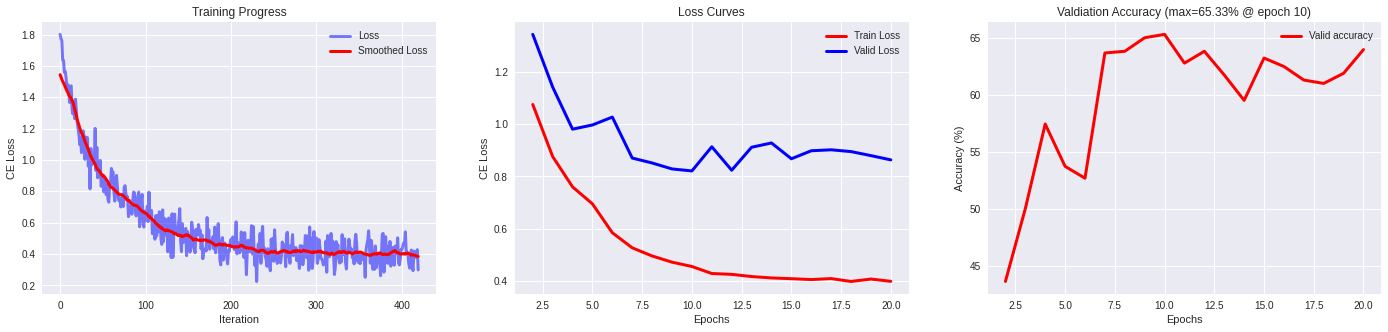

In [65]:
get_plots(train_loss, val_loss, loss_iters, valid_acc, epochs)

In [62]:
# Perfomance on the test set
eval_model(model_1, test_loader, criterion, device)

(53.255208333333336, 1.1015109059711297)

#### PyTorch GRU model (using nn.GRUCell):

In [31]:
class ActionRecognitionGRU(nn.Module):
    def __init__(self, recurrent_module, n_actions=6):
        super().__init__()
        self.encoder = ConvolutionalEncoder(3, 128, 3)
        self.recurrent_module = recurrent_module
        self.classifier = nn.Linear(self.recurrent_module.hidden_size, n_actions)
    
    def forward(self, x):
        x = x.permute((1, 0, 2, 3, 4)).contiguous()
        seq_len, b_size, n_channels, n_rows, n_cols = x.shape
        h = self.init_state(mode="zeros", b_size=b_size, device=x.device)

        # iterating over sequence length
        r_out = []

        for i in range(seq_len):
            r_input = self.encoder(x[i]).view(b_size, Conv_ENC_OUT)
            # print("lstm input", r_input.shape)
            for j, cell in enumerate(self.recurrent_module.cells):
                h[j] = cell(r_input, h[j])
                r_input = h[j]
            r_out.append(r_input)
        
        r_out = torch.stack(r_out, dim=1)

        y = self.classifier(r_out[:, -1, :])

        return y


    
    def init_state(self, mode, b_size, device):
        """ Initializing hidden and cell state """
        if(mode == "zeros"):
            h = [torch.zeros(b_size, self.recurrent_module.hidden_size).to(device) for _ in range(self.recurrent_module.num_layers)]
            # c = [torch.zeros(b_size, self.recurrent_module.hidden_size).to(device) for _ in range(self.recurrent_module.num_layers)]
        elif(mode == "random"):
            h = [torch.zeros(b_size, self.recurrent_module.hidden_size).to(device) for _ in range(self.recurrent_module.num_layers)]
            # c = [torch.zeros(b_size, self.recurrent_module.hidden_size).to(device) for _ in range(self.recurrent_module.num_layers)]
        return h

In [36]:
recurrent_cell = nn.GRUCell
recurrent_module = RecurrentModule(recurrent_cell, Conv_ENC_OUT, 128, 1)
model_2 = ActionRecognitionGRU(recurrent_module)
model_2 = model_2.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_2.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

train_loss_2, val_loss_2, loss_iters_2, valid_acc_2, epochs_2 = train_model(
        model=model_2, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=20
)

Epoch 1 Iter 21: loss 1.21872. : 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


Epoch 1/20
    Train loss: 1.35065
    Valid loss: 1.79441
    Accuracy: 16.666666666666664%




Epoch 2 Iter 21: loss 1.03839. : 100%|██████████| 21/21 [00:09<00:00,  2.33it/s]


Epoch 2/20
    Train loss: 0.97802
    Valid loss: 1.27076
    Accuracy: 48.660714285714285%




Epoch 3 Iter 21: loss 0.82966. : 100%|██████████| 21/21 [00:09<00:00,  2.32it/s]


Epoch 3/20
    Train loss: 0.83555
    Valid loss: 1.13414
    Accuracy: 54.31547619047619%




Epoch 4 Iter 21: loss 0.70356. : 100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Epoch 4/20
    Train loss: 0.69682
    Valid loss: 1.02896
    Accuracy: 57.291666666666664%




Epoch 5 Iter 21: loss 0.63340. : 100%|██████████| 21/21 [00:09<00:00,  2.26it/s]


Epoch 5/20
    Train loss: 0.59625
    Valid loss: 1.07944
    Accuracy: 56.101190476190474%




Epoch 6 Iter 21: loss 0.56852. : 100%|██████████| 21/21 [00:09<00:00,  2.30it/s]


Epoch 6/20
    Train loss: 0.49895
    Valid loss: 1.02015
    Accuracy: 55.50595238095239%




Epoch 7 Iter 21: loss 0.36635. : 100%|██████████| 21/21 [00:09<00:00,  2.30it/s]


Epoch 7/20
    Train loss: 0.4689
    Valid loss: 0.91137
    Accuracy: 59.375%




Epoch 8 Iter 21: loss 0.36870. : 100%|██████████| 21/21 [00:09<00:00,  2.27it/s]


Epoch 8/20
    Train loss: 0.45079
    Valid loss: 0.98172
    Accuracy: 59.077380952380956%




Epoch 9 Iter 21: loss 0.39082. : 100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Epoch 9/20
    Train loss: 0.43831
    Valid loss: 0.91763
    Accuracy: 58.63095238095239%




Epoch 10 Iter 21: loss 0.37148. : 100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Epoch 10/20
    Train loss: 0.42067
    Valid loss: 0.97487
    Accuracy: 59.077380952380956%




Epoch 11 Iter 21: loss 0.52667. : 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


Epoch 11/20
    Train loss: 0.40714
    Valid loss: 0.91919
    Accuracy: 58.779761904761905%




Epoch 12 Iter 21: loss 0.42286. : 100%|██████████| 21/21 [00:09<00:00,  2.32it/s]


Epoch 12/20
    Train loss: 0.39524
    Valid loss: 0.94556
    Accuracy: 57.291666666666664%




Epoch 13 Iter 21: loss 0.37136. : 100%|██████████| 21/21 [00:09<00:00,  2.28it/s]


Epoch 13/20
    Train loss: 0.40163
    Valid loss: 0.9532
    Accuracy: 57.58928571428571%




Epoch 14 Iter 21: loss 0.42447. : 100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Epoch 14/20
    Train loss: 0.39483
    Valid loss: 0.91969
    Accuracy: 59.523809523809526%




Epoch 15 Iter 21: loss 0.46651. : 100%|██████████| 21/21 [00:09<00:00,  2.33it/s]


Epoch 15/20
    Train loss: 0.40069
    Valid loss: 0.96217
    Accuracy: 56.547619047619044%




Epoch 16 Iter 21: loss 0.49001. : 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch 16/20
    Train loss: 0.38649
    Valid loss: 0.95001
    Accuracy: 58.779761904761905%




Epoch 17 Iter 21: loss 0.34558. : 100%|██████████| 21/21 [00:09<00:00,  2.32it/s]


Epoch 17/20
    Train loss: 0.38168
    Valid loss: 0.93095
    Accuracy: 58.779761904761905%




Epoch 18 Iter 21: loss 0.33546. : 100%|██████████| 21/21 [00:09<00:00,  2.32it/s]


Epoch 18/20
    Train loss: 0.3791
    Valid loss: 0.93895
    Accuracy: 58.18452380952381%




Epoch 19 Iter 21: loss 0.32480. : 100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Epoch 19/20
    Train loss: 0.37897
    Valid loss: 0.95716
    Accuracy: 56.845238095238095%




Epoch 20 Iter 21: loss 0.41568. : 100%|██████████| 21/21 [00:09<00:00,  2.32it/s]

Epoch 20/20
    Train loss: 0.38541
    Valid loss: 0.91693
    Accuracy: 59.226190476190474%


Training completed


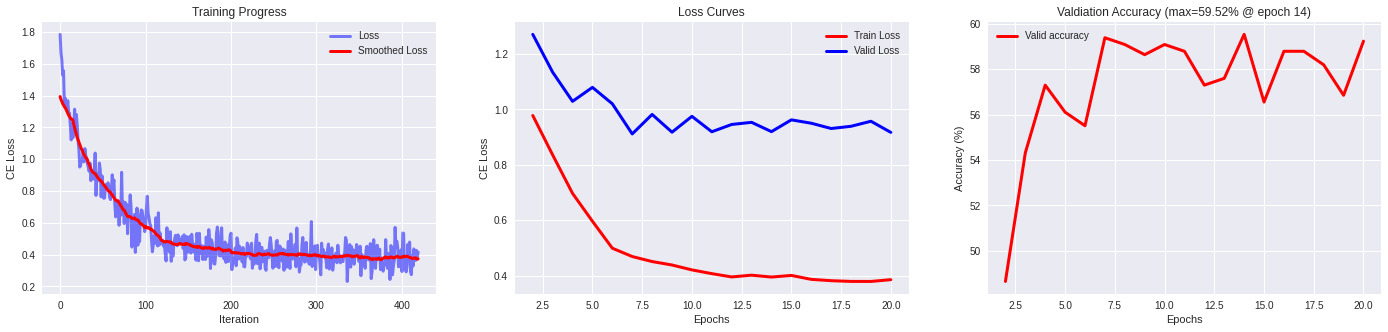

In [37]:
get_plots(train_loss_2, val_loss_2, loss_iters_2, valid_acc_2, epochs_2)